# Modern Era instrumental data

We will use instrumental data for temperature and CO2 measurements.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

## Temperature data

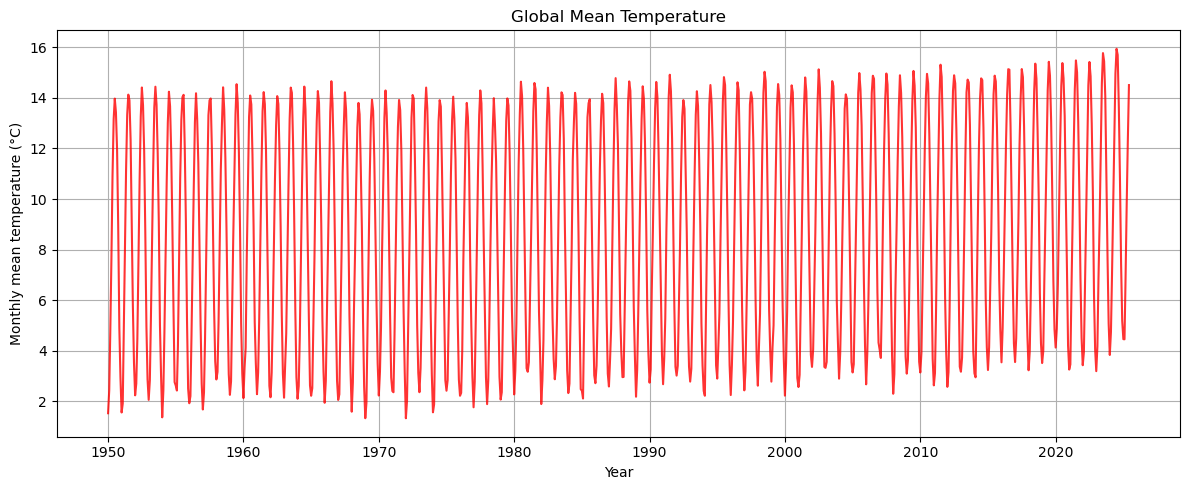

In [2]:
load_data = True
# Below we make use of global mean Temperature from ERA5 Reanalysis data.
if load_data == True:
    global_mean = pd.read_csv("../data/global_mm_temperature.csv", index_col="time", parse_dates=True).squeeze('columns')
    global_mean.name="temperature"
else:
    era5path = r"C:\Users\camen\Desktop\capstone\data\data_stream-moda.nc"
    ds = xr.open_dataset(era5path)
    print(ds)
    # We only need the 2-meter air temperature (t2m) variable, averaged over the globe:
    t2m = ds['t2m'] # accessing xarray
    weights = np.cos(np.deg2rad(ds.latitude)) # computing spatial m ean, standard practice for nc files
    global_mean = t2m.weighted(weights).mean(dim=['latitude', 'longitude']) - 273.15
    global_mean = global_mean.to_series()
    global_mean.index = pd.to_datetime(global_mean.index)
    # Saving computations to csv for quick loading next time:
    weights.to_series().to_csv("../data/latitude_weights.csv", index_label="latitude")
    global_mean.to_csv("../data/global_mm_temperature.csv", index_label="time")

plt.figure(figsize=(12, 5))
plt.plot(global_mean, alpha=0.8, color='red')
plt.title('Global Mean Temperature')
plt.ylabel('Monthly mean temperature (°C)')
plt.xlabel('Year')
plt.grid(True)
plt.tight_layout()
plt.show()

## CO2 data

In [3]:
co2path = r"C:\Users\camen\Documents\GitHub\causal-discovery\data\co2_mm_mlo.csv"
co2 = pd.read_csv(co2path, comment='#')

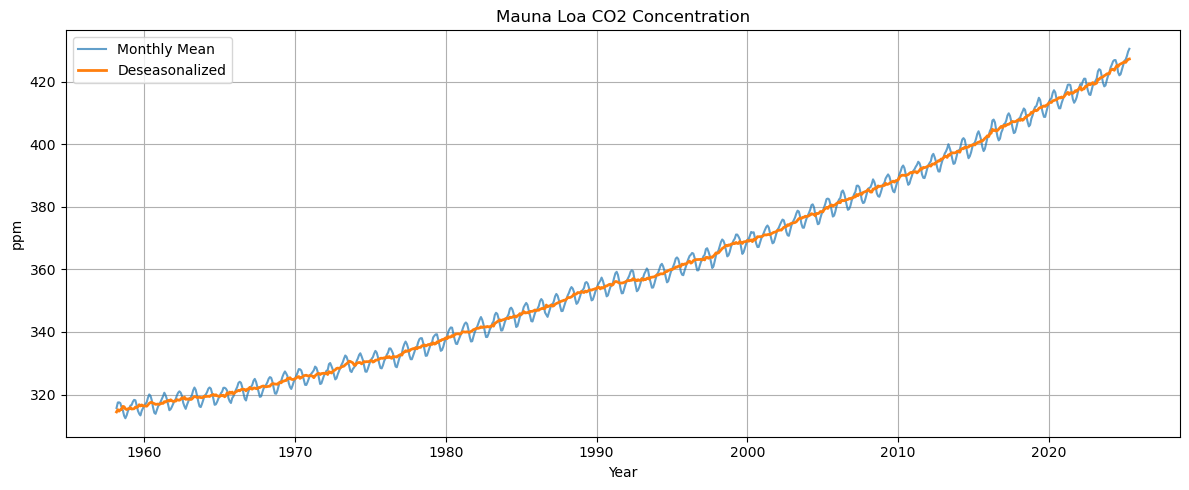

In [4]:
co2 = co2[co2['average'] > 0] # filtering bad values

# datetime index for alignment
co2['date'] = pd.to_datetime(co2[['year', 'month']].assign(day=1))
co2.set_index('date', inplace=True)

plt.figure(figsize=(12, 5))
plt.plot(co2.index, co2['average'], label="Monthly Mean", alpha=0.7)
plt.plot(co2.index, co2['deseasonalized'], label="Deseasonalized",linewidth=2)
plt.title('Mauna Loa CO2 Concentration')
plt.ylabel('ppm')
plt.xlabel('Year')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [5]:
# Align date range
start, end = max(co2.index.min(), global_mean.index.min()), min(co2.index.max(), global_mean.index.max())
co2, global_mean = co2.loc[start:end], global_mean.loc[start:end]

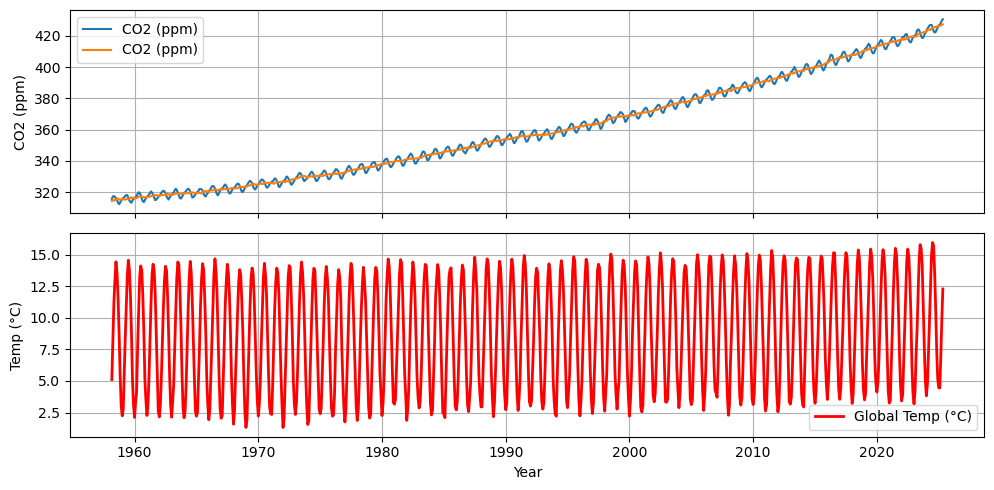

In [14]:
# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 5), sharex=True)
ax1.plot(co2.index, co2['average'], co2['deseasonalized'], label='CO2 (ppm)')
ax2.plot(global_mean.index, global_mean, color='red', linewidth=2, label='Global Temp (°C)')

ax1.set_ylabel('CO2 (ppm)'); ax1.legend(); ax1.grid()
ax2.set_ylabel('Temp (°C)'); ax2.set_xlabel('Year'); ax2.legend(); ax2.grid()

plt.tight_layout()
plt.show()


In [7]:
df = pd.DataFrame({
    'temperature': global_mean,
    'co2': co2['deseasonalized']
}).dropna()
df

,temperature,co2
1958-03-01,5.110323,314.44
1958-04-01,8.125792,315.16
1958-05-01,11.181393,314.69
1958-06-01,12.985923,315.15
1958-07-01,14.422375,315.20
...,...,...
2025-01-01,4.449924,426.35
2025-02-01,4.444533,426.15
2025-03-01,6.837699,426.69
2025-04-01,9.779043,427.13


In [12]:
df.to_pickle("../data/temp_co2_aligned.pkl")